In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import json


In [3]:
W=10

In [4]:
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

2023-04-05 12:19:25.061699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<module 'Forecasting' from '/home/grinenko/anna/time_series/Forecasting.py'>

In [5]:
data = pd.read_csv("DataSet2.csv", sep=";")#, parse_dates=['Timestamp']) #, nrows=10)

In [6]:
columns = data.columns

In [7]:
columns
#CV, DV

Index(['Timestamp', 'ARO', 'SATUR_PRESSURE', 'BOIL_PERCENT', 'OCTANE_NUMBER',
       'percent_01_LAB', 'percent_04_LAB', 'quality_01_LAB', 'pressure_01_LAB',
       'consumption_09', 'consumption_05', 'consumption_08', 'consumption_02',
       'consumption_04', 'consumption_03', 'consumption_07', 'percent_13',
       'percent_05', 'pressure_06', 'pressure_03', 'percent_14', 'pressure_08',
       'percent_12', 'pressure_05', 'percent_08', 'pressure_07', 'percent_10',
       'pressure_10', 'pressure_02', 'percent_02', 'pressure_09',
       'pressure_04', 'percent_09', 'consumption_05.1', 'percent_06',
       'temperature_25', 'percent_07', 'temperature_27', 'percent_11',
       'consumption_06', 'percent_03', 'temperature_29', 'temperature_09',
       'temperature_05', 'temperature_07', 'temperature_17', 'temperature_10',
       'temperature_11', 'temperature_02', 'temperature_13', 'temperature_15',
       'temperature_03', 'temperature_12', 'temperature_06', 'temperature_04',
       'te

In [ ]:
metafile = open("DataSet2_fix.json")
metafile = json.load(metafile)

In [ ]:
CV_DV = [x[0] for x in metafile['ColumnKind'].items() if x[1] == "CV" or x[1] == "DV"]
CV_DV = [x for x in list(columns) if x in CV_DV]
data = data[CV_DV]
CV_DV

In [ ]:
data.shape

In [221]:
K = 30
df = data.groupby(data.index // K).mean() #усреднение
df_np = df.to_numpy()

In [222]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanAbsolutePercentageError
from sklearn.metrics import mean_absolute_error as mae
mase = MeanAbsoluteScaledError(multioutput='raw_values')
mase_uni = MeanAbsoluteScaledError(multioutput='uniform_average')
mape = MeanAbsolutePercentageError(multioutput='raw_values')
# mae = MeanAbsoluteError()


#if ‘raw_values’, returns a full set of errors in case of multioutput input. If ‘uniform_average’, errors of all outputs are averaged with uniform weight.

In [223]:
dataset = df_np[:, :]
# dataset = np.concatenate((dataset[:, :8], dataset[:, 9:]), axis=1)
dataset.shape

(68016, 67)

**__Отбор признаков на минималках__**

In [224]:
#удаление константных
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(0.001)
dataset1 = selector.fit_transform(dataset) 
dataset1.shape

(68016, 65)

In [225]:
set(range(dataset1.shape[-1])) - set(selector.get_feature_names_out(input_features=np.arange(dataset.shape[-1])))

{8, 14}

In [226]:
print(np.unique(dataset[:, 14]))

[0.]


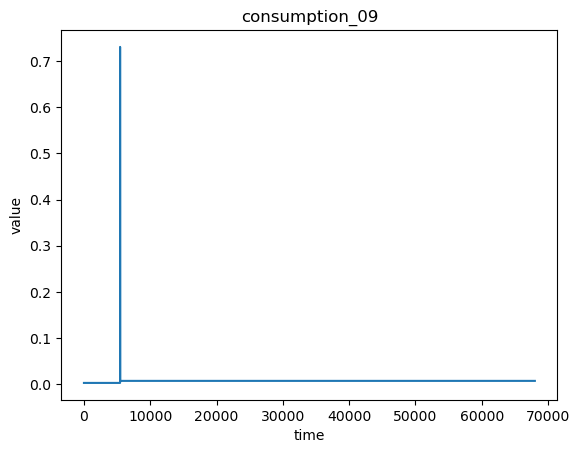

In [227]:
# plt.plot(dataset[:, 8], color="green")
plt.plot(np.concatenate((dataset[:32714, 8], dataset[32717:, 8])))
plt.title("consumption_09")
plt.xlabel("time")
plt.ylabel("value")
plt.show()

In [228]:
# values = np.unique(dataset[:, 8])
# print(values)
# print([len(np.argwhere(dataset[:, 8] == val)) for val in values])
# print(f"Изменение только в {np.argwhere(dataset[1:, 8] - dataset[:-1, 8])}")

**Эти датчики пока выкинем из-за константности: ** 

8: consumption_09

14 : consumption_07 


In [229]:
columns[15], columns[9]

('consumption_07', 'consumption_09')

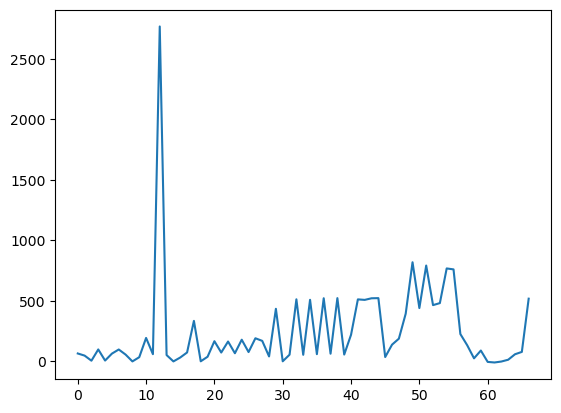

In [230]:
plt.plot(dataset[7])    

In [231]:
# from scipy.signal import correlate
# a = np.array([np.sin(x + 1) for x in range(10)])
# b = np.array([np.sin(x + 2) for x in range(10)])
# c = correlate(a, b, mode="full") #mode='same'
# plt.plot(a, label="a")
# plt.plot(b, label="b")
# plt.plot(c, label="correlation")
# plt.legend()
# c.shape

In [232]:
dataset = dataset1
dataset.shape

(68016, 65)

**Прогнозирование**

In [233]:
dataset = dataset1[:]
dataset.shape

(68016, 65)

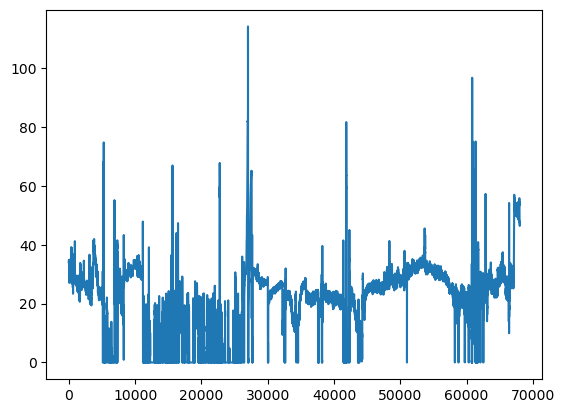

In [234]:
plt.plot(dataset[..., 8])

In [235]:
from sklearn.model_selection import train_test_split
window_sizes_for_clustering = 10
# X, y = dataset[:-window_sizes_for_clustering, ...], dataset[window_sizes_for_clustering:, ...]
# X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
n_split = round(0.2 * dataset.shape[0])
dataset_train, dataset_test = dataset[:-n_split, ...], dataset[-n_split:, ...]

In [236]:
dataset_train.shape, dataset_test.shape

((54413, 65), (13603, 65))

In [237]:
window_sizes_for_clustering = [1, 5, 10]#[1, 5, 10, 15] #[1, 3, 5, 10, 15]
Ns_clusters = [3, 5, 7] #, 3 5, 7]#[2, 5, 7, 9, 11, 13]

In [238]:
clusters_algorithms = ["MeanShift", "Kmeans"] #["Agglomerative"] #["MeanShift"]
clustering_algorithms = []
clustering_algorithms += [Clustering.Kmeans_for_windows(W=W, N_clusters=N_cluster) for W in window_sizes_for_clustering for N_cluster in Ns_clusters]
# clustering_algorithms += [Clustering.MeanShift_for_windows(W=W) for W in window_sizes_for_clustering]
clustering_algorithms += [Clustering.AgglomerativeClustering_for_windows(W=W, N_clusters=N_cluster) for W in window_sizes_for_clustering for N_cluster in Ns_clusters]

Clusterization __init__: W=1, <class 'int'>
Clusterization __init__: W=1, <class 'int'>
Clusterization __init__: W=1, <class 'int'>
Clusterization __init__: W=5, <class 'int'>
Clusterization __init__: W=5, <class 'int'>
Clusterization __init__: W=5, <class 'int'>
Clusterization __init__: W=10, <class 'int'>
Clusterization __init__: W=10, <class 'int'>
Clusterization __init__: W=10, <class 'int'>
Clusterization __init__: W=1, <class 'int'>
Clusterization __init__: W=1, <class 'int'>
Clusterization __init__: W=1, <class 'int'>
Clusterization __init__: W=5, <class 'int'>
Clusterization __init__: W=5, <class 'int'>
Clusterization __init__: W=5, <class 'int'>
Clusterization __init__: W=10, <class 'int'>
Clusterization __init__: W=10, <class 'int'>
Clusterization __init__: W=10, <class 'int'>


In [239]:
clustering_algorithms[0].N_clusters

3

In [240]:
# Ns_clusters = [2]
# window_sizes_for_clustering = [7]

In [241]:
# N, M, Q = 100, 100, 2
# dataset_train = np.column_stack([[np.sin(x / 40) for x in range(N)], [0.01 + np.sin(x / 20) for x in range(N)]])
# # dataset_train = np.array([np.sin(x / 10000) for x in range(N)])[:, None]
# # dataset_train = np.column_stack(([np.sqrt(x / 10) for x in range(N)], [x + ])
# dataset_test = np.column_stack([[np.sin(x / 30) for x in range(M)], [0.01 + np.sin(x / 30)*1.01 for x in range(M)]])

In [242]:
dataset_train.shape

(54413, 65)

In [243]:
# %%time
# a = Clustering.MeanShift_for_windows(W=W).fit_predict(dataset_train)

In [244]:
#clusters_labels, clusters_model 
# clustering_results = [Clustering.apply_clustering(dataset, cur_cluster_alg) for cur_cluster_alg in clustering_algorithms]
# clusters_labels = [x[0] for x in clustering_results]
# clusters_models = [x[1] for x in clustering_results]
clustering_results = [cur_cluster_alg.fit_predict(dataset_train) for cur_cluster_alg in clustering_algorithms]
clusters_labels = clustering_results

Kmeans_for_windows: (54413, 65)
Done
Kmeans_for_windows: (54413, 65)
Done
Kmeans_for_windows: (54413, 65)
Done
Kmeans_for_windows: (54413, 65)
Done
Kmeans_for_windows: (54413, 65)
Done
Kmeans_for_windows: (54413, 65)
Done
Kmeans_for_windows: (54413, 65)
Done
Kmeans_for_windows: (54413, 65)
Done
Kmeans_for_windows: (54413, 65)
Done
<Clustering.AgglomerativeClustering_for_windows object at 0x7f44b367e9a0>: (54413, 65)
Done
<Clustering.AgglomerativeClustering_for_windows object at 0x7f44b367e640>: (54413, 65)
Done
<Clustering.AgglomerativeClustering_for_windows object at 0x7f44b3736820>: (54413, 65)
Done
<Clustering.AgglomerativeClustering_for_windows object at 0x7f44b36fb940>: (54413, 65)
Done
<Clustering.AgglomerativeClustering_for_windows object at 0x7f44b36fb880>: (54413, 65)
Done
<Clustering.AgglomerativeClustering_for_windows object at 0x7f44b3867670>: (54413, 65)
Done
<Clustering.AgglomerativeClustering_for_windows object at 0x7f44b3647640>: (54413, 65)
Done
<Clustering.Agglomerati

(array([ 1478.,     0.,     0.,     0.,     0.,  2815.,     0.,     0.,
            0., 22913.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

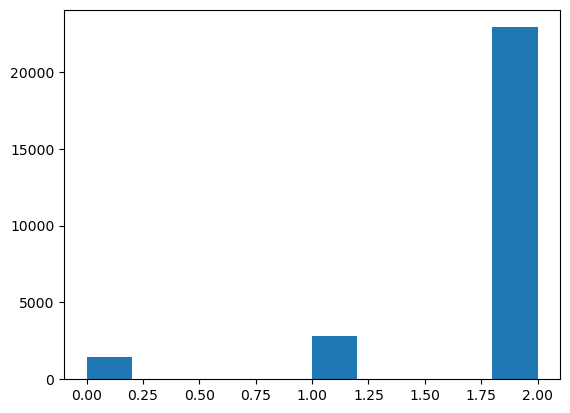

In [172]:
plt.hist(clustering_results[6])

In [245]:
# models, results_training 
# forecasting_training_results = [Forecasting.apply_forecasting_training(dataset, cur_cluster_labels, W=10) for cur_cluster_labels in clusters_labels]
# models = [x[0] for x in forecasting_training_results]
# results_training = [x[1] for x in forecasting_training_results]
# metrics = [x[2] for x in forecasting_training_results]

forecasting_training_results = [Forecasting.apply_forecasting_training_simple_version(dataset_train, cur_cluster_labels, W=W) for cur_cluster_labels in clusters_labels]
models = [x[0] for x in forecasting_training_results]
results_training = [x[1] for x in forecasting_training_results]
metrics_training = [x[2] for x in forecasting_training_results]

N_clusters=3
dataset_windows.shape=(54402, 1, 11, 65), labels.shape=(54402,)
IN Clustering.split_to_clusters: mask.sum()=2952, 2952
IN Clustering.split_to_clusters: mask.sum()=45891, 45891
IN Clustering.split_to_clusters: mask.sum()=5559, 5559
In split_to_train_test: dataset_X.shape=(2952, 10, 65), dataset_y.shape=(2952, 65)
Epoch 1/50
28/28 [==============================] - 1s 36ms/step - loss: 0.3452 - val_loss: 0.7779
Epoch 2/50
28/28 [==============================] - 1s 33ms/step - loss: 0.3378 - val_loss: 0.7711
Epoch 3/50
28/28 [==============================] - 1s 32ms/step - loss: 0.3318 - val_loss: 0.7652
Epoch 4/50
28/28 [==============================] - 1s 31ms/step - loss: 0.3267 - val_loss: 0.7599
Epoch 5/50
28/28 [==============================] - 1s 30ms/step - loss: 0.3223 - val_loss: 0.7550
Epoch 6/50
28/28 [==============================] - 1s 31ms/step - loss: 0.3183 - val_loss: 0.7507
Epoch 7/50
28/28 [==============================] - 1s 30ms/step - loss: 0.3148

431/431 [==============================] - 13s 31ms/step - loss: 0.2331 - val_loss: 0.2389
Epoch 28/50
431/431 [==============================] - 13s 30ms/step - loss: 0.2327 - val_loss: 0.2387
Epoch 29/50
431/431 [==============================] - 12s 29ms/step - loss: 0.2324 - val_loss: 0.2385
Epoch 30/50
431/431 [==============================] - 12s 29ms/step - loss: 0.2321 - val_loss: 0.2383
Epoch 31/50
431/431 [==============================] - 12s 29ms/step - loss: 0.2319 - val_loss: 0.2382
Epoch 32/50
431/431 [==============================] - 12s 29ms/step - loss: 0.2316 - val_loss: 0.2380
Epoch 33/50
431/431 [==============================] - 13s 31ms/step - loss: 0.2314 - val_loss: 0.2378
Epoch 34/50
431/431 [==============================] - 13s 31ms/step - loss: 0.2311 - val_loss: 0.2378
Epoch 35/50
431/431 [==============================] - 13s 30ms/step - loss: 0.2309 - val_loss: 0.2377
Epoch 36/50
431/431 [==============================] - 13s 30ms/step - loss: 0.2307 -

397/397 [==============================] - 11s 29ms/step - loss: 0.2441 - val_loss: 0.2324
Epoch 3/50
397/397 [==============================] - 12s 29ms/step - loss: 0.2385 - val_loss: 0.2291
Epoch 4/50
397/397 [==============================] - 11s 29ms/step - loss: 0.2350 - val_loss: 0.2268
Epoch 5/50
397/397 [==============================] - 12s 29ms/step - loss: 0.2324 - val_loss: 0.2249
Epoch 6/50
397/397 [==============================] - 12s 29ms/step - loss: 0.2301 - val_loss: 0.2232
Epoch 7/50
397/397 [==============================] - 12s 30ms/step - loss: 0.2281 - val_loss: 0.2216
Epoch 8/50
397/397 [==============================] - 12s 29ms/step - loss: 0.2262 - val_loss: 0.2202
Epoch 9/50
397/397 [==============================] - 12s 31ms/step - loss: 0.2244 - val_loss: 0.2189
Epoch 10/50
397/397 [==============================] - 12s 30ms/step - loss: 0.2228 - val_loss: 0.2178
Epoch 11/50
397/397 [==============================] - 12s 30ms/step - loss: 0.2213 - val_lo

49/49 [==============================] - 1s 29ms/step - loss: 0.1837 - val_loss: 0.2974
Epoch 32/50
49/49 [==============================] - 1s 29ms/step - loss: 0.1830 - val_loss: 0.2972
Epoch 33/50
49/49 [==============================] - 1s 30ms/step - loss: 0.1824 - val_loss: 0.2970
Epoch 34/50
49/49 [==============================] - 1s 30ms/step - loss: 0.1818 - val_loss: 0.2968
Epoch 35/50
49/49 [==============================] - 1s 29ms/step - loss: 0.1812 - val_loss: 0.2967
Epoch 36/50
49/49 [==============================] - 2s 32ms/step - loss: 0.1806 - val_loss: 0.2965
Epoch 37/50
49/49 [==============================] - 2s 33ms/step - loss: 0.1800 - val_loss: 0.2963
Epoch 38/50
49/49 [==============================] - 1s 30ms/step - loss: 0.1794 - val_loss: 0.2962
Epoch 39/50
49/49 [==============================] - 2s 31ms/step - loss: 0.1788 - val_loss: 0.2960
Epoch 40/50
49/49 [==============================] - 1s 30ms/step - loss: 0.1783 - val_loss: 0.2959
Epoch 41/50


20/20 [==============================] - 1s 30ms/step - loss: 0.2331 - val_loss: 0.2284
Epoch 11/50
20/20 [==============================] - 1s 31ms/step - loss: 0.2317 - val_loss: 0.2273
Epoch 12/50
20/20 [==============================] - 1s 31ms/step - loss: 0.2303 - val_loss: 0.2264
Epoch 13/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2290 - val_loss: 0.2255
Epoch 14/50
20/20 [==============================] - 1s 32ms/step - loss: 0.2278 - val_loss: 0.2246
Epoch 15/50
20/20 [==============================] - 1s 33ms/step - loss: 0.2266 - val_loss: 0.2238
Epoch 16/50
20/20 [==============================] - 1s 32ms/step - loss: 0.2256 - val_loss: 0.2230
Epoch 17/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2245 - val_loss: 0.2223
Epoch 18/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2236 - val_loss: 0.2216
Epoch 19/50
20/20 [==============================] - 1s 33ms/step - loss: 0.2227 - val_loss: 0.2210
Epoch 20/50


Epoch 41/50
27/27 [==============================] - 1s 30ms/step - loss: 0.2492 - val_loss: 0.5840
Epoch 42/50
27/27 [==============================] - 1s 30ms/step - loss: 0.2485 - val_loss: 0.5827
Epoch 43/50
27/27 [==============================] - 1s 29ms/step - loss: 0.2479 - val_loss: 0.5814
Epoch 44/50
27/27 [==============================] - 1s 30ms/step - loss: 0.2472 - val_loss: 0.5801
Epoch 45/50
27/27 [==============================] - 1s 29ms/step - loss: 0.2466 - val_loss: 0.5789
Epoch 46/50
27/27 [==============================] - 1s 31ms/step - loss: 0.2460 - val_loss: 0.5775
Epoch 47/50
27/27 [==============================] - 1s 30ms/step - loss: 0.2453 - val_loss: 0.5764
Epoch 48/50
27/27 [==============================] - 1s 30ms/step - loss: 0.2447 - val_loss: 0.5753
Epoch 49/50
27/27 [==============================] - 1s 29ms/step - loss: 0.2441 - val_loss: 0.5742
Epoch 50/50
27/27 [==============================] - 1s 29ms/step - loss: 0.2436 - val_loss: 0.5731


Epoch 15/50
17/17 [==============================] - 1s 37ms/step - loss: 0.2297 - val_loss: 0.2253
Epoch 16/50
17/17 [==============================] - 1s 37ms/step - loss: 0.2286 - val_loss: 0.2246
Epoch 17/50
17/17 [==============================] - 1s 34ms/step - loss: 0.2276 - val_loss: 0.2240
Epoch 18/50
17/17 [==============================] - 1s 33ms/step - loss: 0.2266 - val_loss: 0.2235
Epoch 19/50
17/17 [==============================] - 1s 30ms/step - loss: 0.2257 - val_loss: 0.2230
Epoch 20/50
17/17 [==============================] - 1s 31ms/step - loss: 0.2248 - val_loss: 0.2225
Epoch 21/50
17/17 [==============================] - 1s 32ms/step - loss: 0.2240 - val_loss: 0.2220
Epoch 22/50
17/17 [==============================] - 1s 31ms/step - loss: 0.2232 - val_loss: 0.2215
Epoch 23/50
17/17 [==============================] - 1s 31ms/step - loss: 0.2224 - val_loss: 0.2211
Epoch 24/50
17/17 [==============================] - 1s 30ms/step - loss: 0.2217 - val_loss: 0.2207


39/39 [==============================] - 1s 29ms/step - loss: 0.1661 - val_loss: 0.2636
Epoch 46/50
39/39 [==============================] - 1s 29ms/step - loss: 0.1655 - val_loss: 0.2634
Epoch 47/50
39/39 [==============================] - 1s 29ms/step - loss: 0.1650 - val_loss: 0.2631
Epoch 48/50
39/39 [==============================] - 1s 29ms/step - loss: 0.1645 - val_loss: 0.2628
Epoch 49/50
39/39 [==============================] - 1s 29ms/step - loss: 0.1640 - val_loss: 0.2626
Epoch 50/50
39/39 [==============================] - 1s 29ms/step - loss: 0.1635 - val_loss: 0.2623
In calc_results: 2459, 819, 820, sum = 4098
In split_to_train_test: dataset_X.shape=(2870, 10, 65), dataset_y.shape=(2870, 65)
Epoch 1/50
27/27 [==============================] - 1s 36ms/step - loss: 0.3230 - val_loss: 0.6708
Epoch 2/50
27/27 [==============================] - 1s 36ms/step - loss: 0.3165 - val_loss: 0.6652
Epoch 3/50
27/27 [==============================] - 1s 29ms/step - loss: 0.3112 - val_l

147/147 [==============================] - 4s 29ms/step - loss: 0.2056 - val_loss: 0.2292
Epoch 25/50
147/147 [==============================] - 4s 29ms/step - loss: 0.2050 - val_loss: 0.2287
Epoch 26/50
147/147 [==============================] - 4s 29ms/step - loss: 0.2044 - val_loss: 0.2282
Epoch 27/50
147/147 [==============================] - 4s 29ms/step - loss: 0.2039 - val_loss: 0.2277
Epoch 28/50
147/147 [==============================] - 4s 30ms/step - loss: 0.2034 - val_loss: 0.2273
Epoch 29/50
147/147 [==============================] - 4s 29ms/step - loss: 0.2028 - val_loss: 0.2269
Epoch 30/50
147/147 [==============================] - 4s 29ms/step - loss: 0.2023 - val_loss: 0.2265
Epoch 31/50
147/147 [==============================] - 4s 29ms/step - loss: 0.2019 - val_loss: 0.2261
Epoch 32/50
147/147 [==============================] - 4s 30ms/step - loss: 0.2014 - val_loss: 0.2257
Epoch 33/50
147/147 [==============================] - 4s 29ms/step - loss: 0.2010 - val_loss:

12/12 [==============================] - 0s 33ms/step - loss: 1.0255 - val_loss: 0.5074
Epoch 4/50
12/12 [==============================] - 0s 31ms/step - loss: 1.0205 - val_loss: 0.5049
Epoch 5/50
12/12 [==============================] - 0s 32ms/step - loss: 1.0158 - val_loss: 0.5027
Epoch 6/50
12/12 [==============================] - 0s 31ms/step - loss: 1.0115 - val_loss: 0.5007
Epoch 7/50
12/12 [==============================] - 0s 35ms/step - loss: 1.0075 - val_loss: 0.4988
Epoch 8/50
12/12 [==============================] - 0s 37ms/step - loss: 1.0037 - val_loss: 0.4970
Epoch 9/50
12/12 [==============================] - 0s 37ms/step - loss: 1.0002 - val_loss: 0.4953
Epoch 10/50
12/12 [==============================] - 0s 37ms/step - loss: 0.9969 - val_loss: 0.4938
Epoch 11/50
12/12 [==============================] - 0s 31ms/step - loss: 0.9937 - val_loss: 0.4923
Epoch 12/50
12/12 [==============================] - 0s 36ms/step - loss: 0.9907 - val_loss: 0.4910
Epoch 13/50
12/12 

430/430 [==============================] - 13s 29ms/step - loss: 0.2331 - val_loss: 0.2387
Epoch 31/50
430/430 [==============================] - 12s 29ms/step - loss: 0.2328 - val_loss: 0.2385
Epoch 32/50
430/430 [==============================] - 13s 30ms/step - loss: 0.2325 - val_loss: 0.2383
Epoch 33/50
430/430 [==============================] - 13s 29ms/step - loss: 0.2322 - val_loss: 0.2382
Epoch 34/50
430/430 [==============================] - 13s 29ms/step - loss: 0.2320 - val_loss: 0.2381
Epoch 35/50
430/430 [==============================] - 12s 29ms/step - loss: 0.2317 - val_loss: 0.2380
Epoch 36/50
430/430 [==============================] - 12s 29ms/step - loss: 0.2315 - val_loss: 0.2378
Epoch 37/50
430/430 [==============================] - 12s 29ms/step - loss: 0.2313 - val_loss: 0.2376
Epoch 38/50
430/430 [==============================] - 13s 30ms/step - loss: 0.2311 - val_loss: 0.2375
Epoch 39/50
430/430 [==============================] - 13s 30ms/step - loss: 0.2309 -

53/53 [==============================] - 2s 29ms/step - loss: 0.1980 - val_loss: 0.2208
Epoch 10/50
53/53 [==============================] - 2s 29ms/step - loss: 0.1965 - val_loss: 0.2196
Epoch 11/50
53/53 [==============================] - 2s 29ms/step - loss: 0.1951 - val_loss: 0.2185
Epoch 12/50
53/53 [==============================] - 2s 30ms/step - loss: 0.1939 - val_loss: 0.2175
Epoch 13/50
53/53 [==============================] - 2s 29ms/step - loss: 0.1927 - val_loss: 0.2166
Epoch 14/50
53/53 [==============================] - 2s 33ms/step - loss: 0.1916 - val_loss: 0.2157
Epoch 15/50
53/53 [==============================] - 2s 29ms/step - loss: 0.1906 - val_loss: 0.2149
Epoch 16/50
53/53 [==============================] - 2s 33ms/step - loss: 0.1897 - val_loss: 0.2141
Epoch 17/50
53/53 [==============================] - 2s 35ms/step - loss: 0.1887 - val_loss: 0.2134
Epoch 18/50
53/53 [==============================] - 2s 32ms/step - loss: 0.1878 - val_loss: 0.2127
Epoch 19/50


19/19 [==============================] - 1s 31ms/step - loss: 0.7339 - val_loss: 0.6613
Epoch 37/50
19/19 [==============================] - 1s 32ms/step - loss: 0.7329 - val_loss: 0.6606
Epoch 38/50
19/19 [==============================] - 1s 35ms/step - loss: 0.7319 - val_loss: 0.6599
Epoch 39/50
19/19 [==============================] - 1s 37ms/step - loss: 0.7308 - val_loss: 0.6592
Epoch 40/50
19/19 [==============================] - 1s 37ms/step - loss: 0.7299 - val_loss: 0.6586
Epoch 41/50
19/19 [==============================] - 1s 37ms/step - loss: 0.7289 - val_loss: 0.6579
Epoch 42/50
19/19 [==============================] - 1s 32ms/step - loss: 0.7279 - val_loss: 0.6572
Epoch 43/50
19/19 [==============================] - 1s 31ms/step - loss: 0.7270 - val_loss: 0.6565
Epoch 44/50
19/19 [==============================] - 1s 30ms/step - loss: 0.7261 - val_loss: 0.6559
Epoch 45/50
19/19 [==============================] - 1s 31ms/step - loss: 0.7252 - val_loss: 0.6553
Epoch 46/50


20/20 [==============================] - 1s 31ms/step - loss: 0.2275 - val_loss: 0.2263
Epoch 15/50
20/20 [==============================] - 1s 31ms/step - loss: 0.2263 - val_loss: 0.2256
Epoch 16/50
20/20 [==============================] - 1s 31ms/step - loss: 0.2253 - val_loss: 0.2250
Epoch 17/50
20/20 [==============================] - 1s 32ms/step - loss: 0.2242 - val_loss: 0.2244
Epoch 18/50
20/20 [==============================] - 1s 34ms/step - loss: 0.2233 - val_loss: 0.2239
Epoch 19/50
20/20 [==============================] - 1s 36ms/step - loss: 0.2223 - val_loss: 0.2233
Epoch 20/50
20/20 [==============================] - 1s 36ms/step - loss: 0.2214 - val_loss: 0.2228
Epoch 21/50
20/20 [==============================] - 1s 36ms/step - loss: 0.2206 - val_loss: 0.2223
Epoch 22/50
20/20 [==============================] - 1s 36ms/step - loss: 0.2198 - val_loss: 0.2218
Epoch 23/50
20/20 [==============================] - 1s 32ms/step - loss: 0.2190 - val_loss: 0.2213
Epoch 24/50


Epoch 45/50
27/27 [==============================] - 1s 32ms/step - loss: 0.2322 - val_loss: 0.5357
Epoch 46/50
27/27 [==============================] - 1s 31ms/step - loss: 0.2317 - val_loss: 0.5348
Epoch 47/50
27/27 [==============================] - 1s 30ms/step - loss: 0.2312 - val_loss: 0.5338
Epoch 48/50
27/27 [==============================] - 1s 30ms/step - loss: 0.2307 - val_loss: 0.5329
Epoch 49/50
27/27 [==============================] - 1s 29ms/step - loss: 0.2302 - val_loss: 0.5320
Epoch 50/50
27/27 [==============================] - 1s 32ms/step - loss: 0.2298 - val_loss: 0.5312
In calc_results: 1726, 576, 575, sum = 2877
In split_to_train_test: dataset_X.shape=(5168, 10, 65), dataset_y.shape=(5168, 65)
Epoch 1/50
49/49 [==============================] - 2s 31ms/step - loss: 0.2268 - val_loss: 0.3276
Epoch 2/50
49/49 [==============================] - 1s 29ms/step - loss: 0.2220 - val_loss: 0.3236
Epoch 3/50
49/49 [==============================] - 1s 30ms/step - loss: 0.

5/5 [==============================] - 0s 35ms/step - loss: 0.0616 - val_loss: 0.0633
Epoch 21/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0610 - val_loss: 0.0627
Epoch 22/50
5/5 [==============================] - 0s 38ms/step - loss: 0.0605 - val_loss: 0.0621
Epoch 23/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0599 - val_loss: 0.0616
Epoch 24/50
5/5 [==============================] - 0s 38ms/step - loss: 0.0594 - val_loss: 0.0611
Epoch 25/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0589 - val_loss: 0.0606
Epoch 26/50
5/5 [==============================] - 0s 37ms/step - loss: 0.0585 - val_loss: 0.0601
Epoch 27/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0580 - val_loss: 0.0597
Epoch 28/50
5/5 [==============================] - 0s 37ms/step - loss: 0.0576 - val_loss: 0.0593
Epoch 29/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0571 - val_loss: 0.0588
Epoch 30/50
5/5 [===============

Epoch 1/50
42/42 [==============================] - 1s 33ms/step - loss: 0.2192 - val_loss: 0.3156
Epoch 2/50
42/42 [==============================] - 1s 35ms/step - loss: 0.2147 - val_loss: 0.3126
Epoch 3/50
42/42 [==============================] - 1s 29ms/step - loss: 0.2113 - val_loss: 0.3102
Epoch 4/50
42/42 [==============================] - 1s 29ms/step - loss: 0.2087 - val_loss: 0.3082
Epoch 5/50
42/42 [==============================] - 1s 29ms/step - loss: 0.2065 - val_loss: 0.3066
Epoch 6/50
42/42 [==============================] - 1s 29ms/step - loss: 0.2047 - val_loss: 0.3051
Epoch 7/50
42/42 [==============================] - 1s 29ms/step - loss: 0.2030 - val_loss: 0.3038
Epoch 8/50
42/42 [==============================] - 1s 29ms/step - loss: 0.2015 - val_loss: 0.3026
Epoch 9/50
42/42 [==============================] - 1s 29ms/step - loss: 0.2002 - val_loss: 0.3015
Epoch 10/50
42/42 [==============================] - 1s 29ms/step - loss: 0.1989 - val_loss: 0.3004
Epoch 11/

163/163 [==============================] - 5s 29ms/step - loss: 0.2479 - val_loss: 0.2558
Epoch 32/50
163/163 [==============================] - 5s 29ms/step - loss: 0.2473 - val_loss: 0.2555
Epoch 33/50
163/163 [==============================] - 5s 29ms/step - loss: 0.2466 - val_loss: 0.2552
Epoch 34/50
163/163 [==============================] - 5s 31ms/step - loss: 0.2460 - val_loss: 0.2549
Epoch 35/50
163/163 [==============================] - 5s 30ms/step - loss: 0.2454 - val_loss: 0.2547
Epoch 36/50
163/163 [==============================] - 5s 29ms/step - loss: 0.2448 - val_loss: 0.2544
Epoch 37/50
163/163 [==============================] - 5s 31ms/step - loss: 0.2442 - val_loss: 0.2542
Epoch 38/50
163/163 [==============================] - 5s 29ms/step - loss: 0.2437 - val_loss: 0.2540
Epoch 39/50
163/163 [==============================] - 5s 29ms/step - loss: 0.2432 - val_loss: 0.2538
Epoch 40/50
163/163 [==============================] - 5s 30ms/step - loss: 0.2427 - val_loss:

249/249 [==============================] - 7s 29ms/step - loss: 0.2150 - val_loss: 0.2211
Epoch 11/50
249/249 [==============================] - 7s 29ms/step - loss: 0.2137 - val_loss: 0.2200
Epoch 12/50
249/249 [==============================] - 7s 29ms/step - loss: 0.2125 - val_loss: 0.2191
Epoch 13/50
249/249 [==============================] - 7s 29ms/step - loss: 0.2113 - val_loss: 0.2182
Epoch 14/50
249/249 [==============================] - 7s 30ms/step - loss: 0.2102 - val_loss: 0.2173
Epoch 15/50
249/249 [==============================] - 7s 29ms/step - loss: 0.2092 - val_loss: 0.2165
Epoch 16/50
249/249 [==============================] - 7s 29ms/step - loss: 0.2082 - val_loss: 0.2158
Epoch 17/50
249/249 [==============================] - 7s 29ms/step - loss: 0.2073 - val_loss: 0.2151
Epoch 18/50
249/249 [==============================] - 7s 29ms/step - loss: 0.2064 - val_loss: 0.2144
Epoch 19/50
249/249 [==============================] - 7s 29ms/step - loss: 0.2056 - val_loss:

23/23 [==============================] - 1s 31ms/step - loss: 0.3246 - val_loss: 0.4435
Epoch 41/50
23/23 [==============================] - 1s 33ms/step - loss: 0.3236 - val_loss: 0.4425
Epoch 42/50
23/23 [==============================] - 1s 34ms/step - loss: 0.3226 - val_loss: 0.4416
Epoch 43/50
23/23 [==============================] - 1s 32ms/step - loss: 0.3216 - val_loss: 0.4406
Epoch 44/50
23/23 [==============================] - 1s 31ms/step - loss: 0.3206 - val_loss: 0.4397
Epoch 45/50
23/23 [==============================] - 1s 35ms/step - loss: 0.3197 - val_loss: 0.4389
Epoch 46/50
23/23 [==============================] - 1s 36ms/step - loss: 0.3189 - val_loss: 0.4380
Epoch 47/50
23/23 [==============================] - 1s 36ms/step - loss: 0.3180 - val_loss: 0.4371
Epoch 48/50
23/23 [==============================] - 1s 34ms/step - loss: 0.3172 - val_loss: 0.4363
Epoch 49/50
23/23 [==============================] - 1s 31ms/step - loss: 0.3163 - val_loss: 0.4355
Epoch 50/50


430/430 [==============================] - 13s 29ms/step - loss: 0.2410 - val_loss: 0.2435
Epoch 17/50
430/430 [==============================] - 13s 30ms/step - loss: 0.2400 - val_loss: 0.2429
Epoch 18/50
430/430 [==============================] - 12s 29ms/step - loss: 0.2391 - val_loss: 0.2424
Epoch 19/50
430/430 [==============================] - 13s 30ms/step - loss: 0.2384 - val_loss: 0.2420
Epoch 20/50
430/430 [==============================] - 12s 29ms/step - loss: 0.2378 - val_loss: 0.2417
Epoch 21/50
430/430 [==============================] - 12s 29ms/step - loss: 0.2372 - val_loss: 0.2413
Epoch 22/50
430/430 [==============================] - 12s 29ms/step - loss: 0.2367 - val_loss: 0.2410
Epoch 23/50
430/430 [==============================] - 12s 29ms/step - loss: 0.2362 - val_loss: 0.2407
Epoch 24/50
430/430 [==============================] - 12s 29ms/step - loss: 0.2358 - val_loss: 0.2404
Epoch 25/50
430/430 [==============================] - 12s 29ms/step - loss: 0.2354 -

Epoch 46/50
28/28 [==============================] - 1s 35ms/step - loss: 0.2508 - val_loss: 0.6178
Epoch 47/50
28/28 [==============================] - 1s 34ms/step - loss: 0.2502 - val_loss: 0.6166
Epoch 48/50
28/28 [==============================] - 1s 35ms/step - loss: 0.2497 - val_loss: 0.6155
Epoch 49/50
28/28 [==============================] - 1s 32ms/step - loss: 0.2491 - val_loss: 0.6143
Epoch 50/50
28/28 [==============================] - 1s 36ms/step - loss: 0.2486 - val_loss: 0.6132
In calc_results: 1773, 591, 591, sum = 2955
N_clusters=5
dataset_windows.shape=(54402, 1, 11, 65), labels.shape=(54402,)
IN Clustering.split_to_clusters: mask.sum()=5151, 5151
IN Clustering.split_to_clusters: mask.sum()=2870, 2870
IN Clustering.split_to_clusters: mask.sum()=2040, 2040
IN Clustering.split_to_clusters: mask.sum()=2074, 2074
IN Clustering.split_to_clusters: mask.sum()=42267, 42267
In split_to_train_test: dataset_X.shape=(5151, 10, 65), dataset_y.shape=(5151, 65)
Epoch 1/50
49/49 [=

27/27 [==============================] - 1s 29ms/step - loss: 0.2439 - val_loss: 0.5315
Epoch 23/50
27/27 [==============================] - 1s 33ms/step - loss: 0.2426 - val_loss: 0.5297
Epoch 24/50
27/27 [==============================] - 1s 32ms/step - loss: 0.2415 - val_loss: 0.5279
Epoch 25/50
27/27 [==============================] - 1s 33ms/step - loss: 0.2404 - val_loss: 0.5262
Epoch 26/50
27/27 [==============================] - 1s 35ms/step - loss: 0.2393 - val_loss: 0.5245
Epoch 27/50
27/27 [==============================] - 1s 30ms/step - loss: 0.2383 - val_loss: 0.5229
Epoch 28/50
27/27 [==============================] - 1s 33ms/step - loss: 0.2373 - val_loss: 0.5212
Epoch 29/50
27/27 [==============================] - 1s 36ms/step - loss: 0.2364 - val_loss: 0.5197
Epoch 30/50
27/27 [==============================] - 1s 34ms/step - loss: 0.2355 - val_loss: 0.5182
Epoch 31/50
27/27 [==============================] - 1s 31ms/step - loss: 0.2347 - val_loss: 0.5168
Epoch 32/50


20/20 [==============================] - 1s 32ms/step - loss: 0.2493 - val_loss: 0.2422
Epoch 2/50
20/20 [==============================] - 1s 31ms/step - loss: 0.2454 - val_loss: 0.2401
Epoch 3/50
20/20 [==============================] - 1s 31ms/step - loss: 0.2420 - val_loss: 0.2383
Epoch 4/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2390 - val_loss: 0.2366
Epoch 5/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2365 - val_loss: 0.2351
Epoch 6/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2342 - val_loss: 0.2337
Epoch 7/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2322 - val_loss: 0.2325
Epoch 8/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2303 - val_loss: 0.2313
Epoch 9/50
20/20 [==============================] - 1s 31ms/step - loss: 0.2286 - val_loss: 0.2303
Epoch 10/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2271 - val_loss: 0.2293
Epoch 11/50
20/20 [=

397/397 [==============================] - 13s 32ms/step - loss: 0.2125 - val_loss: 0.2125
Epoch 32/50
397/397 [==============================] - 12s 30ms/step - loss: 0.2123 - val_loss: 0.2123
Epoch 33/50
397/397 [==============================] - 12s 30ms/step - loss: 0.2120 - val_loss: 0.2122
Epoch 34/50
397/397 [==============================] - 12s 30ms/step - loss: 0.2118 - val_loss: 0.2121
Epoch 35/50
397/397 [==============================] - 12s 31ms/step - loss: 0.2116 - val_loss: 0.2119
Epoch 36/50
397/397 [==============================] - 12s 30ms/step - loss: 0.2114 - val_loss: 0.2119
Epoch 37/50
397/397 [==============================] - 12s 30ms/step - loss: 0.2112 - val_loss: 0.2117
Epoch 38/50
397/397 [==============================] - 12s 31ms/step - loss: 0.2110 - val_loss: 0.2115
Epoch 39/50
397/397 [==============================] - 12s 31ms/step - loss: 0.2108 - val_loss: 0.2115
Epoch 40/50
397/397 [==============================] - 12s 30ms/step - loss: 0.2107 -

18/18 [==============================] - 1s 30ms/step - loss: 0.2416 - val_loss: 0.2325
Epoch 6/50
18/18 [==============================] - 1s 31ms/step - loss: 0.2393 - val_loss: 0.2315
Epoch 7/50
18/18 [==============================] - 1s 31ms/step - loss: 0.2373 - val_loss: 0.2305
Epoch 8/50
18/18 [==============================] - 1s 30ms/step - loss: 0.2355 - val_loss: 0.2296
Epoch 9/50
18/18 [==============================] - 1s 31ms/step - loss: 0.2339 - val_loss: 0.2288
Epoch 10/50
18/18 [==============================] - 1s 31ms/step - loss: 0.2324 - val_loss: 0.2281
Epoch 11/50
18/18 [==============================] - 1s 31ms/step - loss: 0.2310 - val_loss: 0.2274
Epoch 12/50
18/18 [==============================] - 1s 30ms/step - loss: 0.2298 - val_loss: 0.2269
Epoch 13/50
18/18 [==============================] - 1s 32ms/step - loss: 0.2286 - val_loss: 0.2263
Epoch 14/50
18/18 [==============================] - 1s 30ms/step - loss: 0.2275 - val_loss: 0.2258
Epoch 15/50
18/1

143/143 [==============================] - 4s 30ms/step - loss: 0.2033 - val_loss: 0.2309
Epoch 36/50
143/143 [==============================] - 4s 29ms/step - loss: 0.2029 - val_loss: 0.2305
Epoch 37/50
143/143 [==============================] - 4s 29ms/step - loss: 0.2025 - val_loss: 0.2303
Epoch 38/50
143/143 [==============================] - 4s 29ms/step - loss: 0.2022 - val_loss: 0.2300
Epoch 39/50
143/143 [==============================] - 4s 29ms/step - loss: 0.2018 - val_loss: 0.2298
Epoch 40/50
143/143 [==============================] - 4s 30ms/step - loss: 0.2015 - val_loss: 0.2295
Epoch 41/50
143/143 [==============================] - 4s 30ms/step - loss: 0.2011 - val_loss: 0.2293
Epoch 42/50
143/143 [==============================] - 4s 29ms/step - loss: 0.2008 - val_loss: 0.2291
Epoch 43/50
143/143 [==============================] - 4s 29ms/step - loss: 0.2005 - val_loss: 0.2289
Epoch 44/50
143/143 [==============================] - 4s 29ms/step - loss: 0.2002 - val_loss:

12/12 [==============================] - 0s 37ms/step - loss: 0.9635 - val_loss: 0.4453
Epoch 14/50
12/12 [==============================] - 0s 33ms/step - loss: 0.9610 - val_loss: 0.4441
Epoch 15/50
12/12 [==============================] - 0s 35ms/step - loss: 0.9586 - val_loss: 0.4428
Epoch 16/50
12/12 [==============================] - 0s 35ms/step - loss: 0.9563 - val_loss: 0.4416
Epoch 17/50
12/12 [==============================] - 0s 33ms/step - loss: 0.9541 - val_loss: 0.4404
Epoch 18/50
12/12 [==============================] - 0s 37ms/step - loss: 0.9520 - val_loss: 0.4393
Epoch 19/50
12/12 [==============================] - 0s 33ms/step - loss: 0.9499 - val_loss: 0.4382
Epoch 20/50
12/12 [==============================] - 0s 38ms/step - loss: 0.9479 - val_loss: 0.4371
Epoch 21/50
12/12 [==============================] - 0s 37ms/step - loss: 0.9460 - val_loss: 0.4361
Epoch 22/50
12/12 [==============================] - 0s 31ms/step - loss: 0.9441 - val_loss: 0.4351
Epoch 23/50


Epoch 44/50
39/39 [==============================] - 1s 30ms/step - loss: 0.1699 - val_loss: 0.2744
Epoch 45/50
39/39 [==============================] - 1s 30ms/step - loss: 0.1694 - val_loss: 0.2742
Epoch 46/50
39/39 [==============================] - 1s 30ms/step - loss: 0.1689 - val_loss: 0.2739
Epoch 47/50
39/39 [==============================] - 1s 31ms/step - loss: 0.1684 - val_loss: 0.2736
Epoch 48/50
39/39 [==============================] - 1s 29ms/step - loss: 0.1679 - val_loss: 0.2734
Epoch 49/50
39/39 [==============================] - 1s 30ms/step - loss: 0.1674 - val_loss: 0.2732
Epoch 50/50
39/39 [==============================] - 1s 30ms/step - loss: 0.1670 - val_loss: 0.2729
In calc_results: 2436, 812, 812, sum = 4060
In split_to_train_test: dataset_X.shape=(5484, 10, 65), dataset_y.shape=(5484, 65)
Epoch 1/50
52/52 [==============================] - 2s 31ms/step - loss: 0.3498 - val_loss: 0.4150
Epoch 2/50
52/52 [==============================] - 2s 34ms/step - loss: 0

421/421 [==============================] - 13s 30ms/step - loss: 0.2394 - val_loss: 0.2453
Epoch 21/50
421/421 [==============================] - 12s 29ms/step - loss: 0.2388 - val_loss: 0.2449
Epoch 22/50
421/421 [==============================] - 12s 29ms/step - loss: 0.2382 - val_loss: 0.2446
Epoch 23/50
421/421 [==============================] - 12s 29ms/step - loss: 0.2376 - val_loss: 0.2443
Epoch 24/50
421/421 [==============================] - 12s 29ms/step - loss: 0.2371 - val_loss: 0.2441
Epoch 25/50
421/421 [==============================] - 13s 31ms/step - loss: 0.2367 - val_loss: 0.2438
Epoch 26/50
421/421 [==============================] - 14s 32ms/step - loss: 0.2363 - val_loss: 0.2435
Epoch 27/50
421/421 [==============================] - 13s 30ms/step - loss: 0.2359 - val_loss: 0.2433
Epoch 28/50
421/421 [==============================] - 14s 34ms/step - loss: 0.2356 - val_loss: 0.2431
Epoch 29/50
421/421 [==============================] - 12s 29ms/step - loss: 0.2352 -

Epoch 50/50
24/24 [==============================] - 1s 30ms/step - loss: 0.3538 - val_loss: 0.5027
In calc_results: 1475, 492, 492, sum = 2459
In split_to_train_test: dataset_X.shape=(7059, 10, 65), dataset_y.shape=(7059, 65)
Epoch 1/50
67/67 [==============================] - 2s 29ms/step - loss: 0.2250 - val_loss: 0.2945
Epoch 2/50
67/67 [==============================] - 2s 29ms/step - loss: 0.2182 - val_loss: 0.2901
Epoch 3/50
67/67 [==============================] - 2s 29ms/step - loss: 0.2135 - val_loss: 0.2868
Epoch 4/50
67/67 [==============================] - 2s 30ms/step - loss: 0.2099 - val_loss: 0.2842
Epoch 5/50
67/67 [==============================] - 2s 30ms/step - loss: 0.2070 - val_loss: 0.2821
Epoch 6/50
67/67 [==============================] - 2s 30ms/step - loss: 0.2046 - val_loss: 0.2803
Epoch 7/50
67/67 [==============================] - 2s 30ms/step - loss: 0.2026 - val_loss: 0.2788
Epoch 8/50
67/67 [==============================] - 2s 30ms/step - loss: 0.2008 

16/16 [==============================] - 0s 31ms/step - loss: 0.5753 - val_loss: 0.7501
Epoch 27/50
16/16 [==============================] - 0s 31ms/step - loss: 0.5742 - val_loss: 0.7490
Epoch 28/50
16/16 [==============================] - 0s 31ms/step - loss: 0.5731 - val_loss: 0.7479
Epoch 29/50
16/16 [==============================] - 1s 31ms/step - loss: 0.5720 - val_loss: 0.7468
Epoch 30/50
16/16 [==============================] - 1s 34ms/step - loss: 0.5709 - val_loss: 0.7456
Epoch 31/50
16/16 [==============================] - 1s 36ms/step - loss: 0.5698 - val_loss: 0.7445
Epoch 32/50
16/16 [==============================] - 1s 32ms/step - loss: 0.5688 - val_loss: 0.7435
Epoch 33/50
16/16 [==============================] - 0s 30ms/step - loss: 0.5678 - val_loss: 0.7425
Epoch 34/50
16/16 [==============================] - 1s 34ms/step - loss: 0.5668 - val_loss: 0.7415
Epoch 35/50
16/16 [==============================] - 1s 36ms/step - loss: 0.5658 - val_loss: 0.7404
Epoch 36/50


19/19 [==============================] - 1s 38ms/step - loss: 0.2445 - val_loss: 0.2540
Epoch 5/50
19/19 [==============================] - 1s 33ms/step - loss: 0.2418 - val_loss: 0.2522
Epoch 6/50
19/19 [==============================] - 1s 34ms/step - loss: 0.2395 - val_loss: 0.2505
Epoch 7/50
19/19 [==============================] - 1s 35ms/step - loss: 0.2374 - val_loss: 0.2491
Epoch 8/50
19/19 [==============================] - 1s 37ms/step - loss: 0.2355 - val_loss: 0.2477
Epoch 9/50
19/19 [==============================] - 1s 37ms/step - loss: 0.2338 - val_loss: 0.2465
Epoch 10/50
19/19 [==============================] - 1s 38ms/step - loss: 0.2322 - val_loss: 0.2454
Epoch 11/50
19/19 [==============================] - 1s 34ms/step - loss: 0.2307 - val_loss: 0.2443
Epoch 12/50
19/19 [==============================] - 1s 37ms/step - loss: 0.2293 - val_loss: 0.2433
Epoch 13/50
19/19 [==============================] - 1s 37ms/step - loss: 0.2280 - val_loss: 0.2424
Epoch 14/50
19/19

Epoch 35/50
24/24 [==============================] - 1s 30ms/step - loss: 0.3638 - val_loss: 0.5162
Epoch 36/50
24/24 [==============================] - 1s 30ms/step - loss: 0.3627 - val_loss: 0.5151
Epoch 37/50
24/24 [==============================] - 1s 30ms/step - loss: 0.3617 - val_loss: 0.5141
Epoch 38/50
24/24 [==============================] - 1s 30ms/step - loss: 0.3607 - val_loss: 0.5131
Epoch 39/50
24/24 [==============================] - 1s 30ms/step - loss: 0.3597 - val_loss: 0.5120
Epoch 40/50
24/24 [==============================] - 1s 30ms/step - loss: 0.3587 - val_loss: 0.5111
Epoch 41/50
24/24 [==============================] - 1s 30ms/step - loss: 0.3578 - val_loss: 0.5100
Epoch 42/50
24/24 [==============================] - 1s 32ms/step - loss: 0.3569 - val_loss: 0.5090
Epoch 43/50
24/24 [==============================] - 1s 32ms/step - loss: 0.3560 - val_loss: 0.5081
Epoch 44/50
24/24 [==============================] - 1s 31ms/step - loss: 0.3551 - val_loss: 0.5071


370/370 [==============================] - 11s 29ms/step - loss: 0.2206 - val_loss: 0.2152
Epoch 10/50
370/370 [==============================] - 11s 29ms/step - loss: 0.2188 - val_loss: 0.2139
Epoch 11/50
370/370 [==============================] - 11s 29ms/step - loss: 0.2171 - val_loss: 0.2128
Epoch 12/50
370/370 [==============================] - 11s 30ms/step - loss: 0.2155 - val_loss: 0.2117
Epoch 13/50
370/370 [==============================] - 11s 29ms/step - loss: 0.2140 - val_loss: 0.2107
Epoch 14/50
370/370 [==============================] - 11s 30ms/step - loss: 0.2126 - val_loss: 0.2098
Epoch 15/50
370/370 [==============================] - 11s 29ms/step - loss: 0.2114 - val_loss: 0.2090
Epoch 16/50
370/370 [==============================] - 11s 29ms/step - loss: 0.2103 - val_loss: 0.2083
Epoch 17/50
370/370 [==============================] - 11s 30ms/step - loss: 0.2094 - val_loss: 0.2077
Epoch 18/50
370/370 [==============================] - 11s 30ms/step - loss: 0.2086 -

48/48 [==============================] - 1s 29ms/step - loss: 0.1766 - val_loss: 0.3009
Epoch 39/50
48/48 [==============================] - 1s 29ms/step - loss: 0.1760 - val_loss: 0.3007
Epoch 40/50
48/48 [==============================] - 1s 29ms/step - loss: 0.1755 - val_loss: 0.3006
Epoch 41/50
48/48 [==============================] - 1s 29ms/step - loss: 0.1750 - val_loss: 0.3005
Epoch 42/50
48/48 [==============================] - 1s 30ms/step - loss: 0.1744 - val_loss: 0.3003
Epoch 43/50
48/48 [==============================] - 1s 30ms/step - loss: 0.1739 - val_loss: 0.3002
Epoch 44/50
48/48 [==============================] - 1s 29ms/step - loss: 0.1734 - val_loss: 0.3000
Epoch 45/50
48/48 [==============================] - 2s 33ms/step - loss: 0.1730 - val_loss: 0.3000
Epoch 46/50
48/48 [==============================] - 1s 29ms/step - loss: 0.1725 - val_loss: 0.2998
Epoch 47/50
48/48 [==============================] - 1s 29ms/step - loss: 0.1721 - val_loss: 0.2997
Epoch 48/50


24/24 [==============================] - 1s 31ms/step - loss: 0.3933 - val_loss: 0.5416
Epoch 18/50
24/24 [==============================] - 1s 30ms/step - loss: 0.3914 - val_loss: 0.5399
Epoch 19/50
24/24 [==============================] - 1s 31ms/step - loss: 0.3895 - val_loss: 0.5383
Epoch 20/50
24/24 [==============================] - 1s 34ms/step - loss: 0.3877 - val_loss: 0.5366
Epoch 21/50
24/24 [==============================] - 1s 35ms/step - loss: 0.3859 - val_loss: 0.5350
Epoch 22/50
24/24 [==============================] - 1s 35ms/step - loss: 0.3842 - val_loss: 0.5336
Epoch 23/50
24/24 [==============================] - 1s 35ms/step - loss: 0.3826 - val_loss: 0.5321
Epoch 24/50
24/24 [==============================] - 1s 35ms/step - loss: 0.3810 - val_loss: 0.5306
Epoch 25/50
24/24 [==============================] - 1s 35ms/step - loss: 0.3794 - val_loss: 0.5291
Epoch 26/50
24/24 [==============================] - 1s 35ms/step - loss: 0.3779 - val_loss: 0.5278
Epoch 27/50


Epoch 48/50
11/11 [==============================] - 0s 32ms/step - loss: 0.9497 - val_loss: 0.4540
Epoch 49/50
11/11 [==============================] - 0s 37ms/step - loss: 0.9484 - val_loss: 0.4534
Epoch 50/50
11/11 [==============================] - 0s 38ms/step - loss: 0.9472 - val_loss: 0.4529
In calc_results: 701, 233, 234, sum = 1168
In split_to_train_test: dataset_X.shape=(436, 10, 65), dataset_y.shape=(436, 65)
Epoch 1/50
5/5 [==============================] - 0s 47ms/step - loss: 0.1142 - val_loss: 0.0933
Epoch 2/50
5/5 [==============================] - 0s 39ms/step - loss: 0.1125 - val_loss: 0.0912
Epoch 3/50
5/5 [==============================] - 0s 37ms/step - loss: 0.1110 - val_loss: 0.0891
Epoch 4/50
5/5 [==============================] - 0s 36ms/step - loss: 0.1094 - val_loss: 0.0871
Epoch 5/50
5/5 [==============================] - 0s 35ms/step - loss: 0.1080 - val_loss: 0.0852
Epoch 6/50
5/5 [==============================] - 0s 36ms/step - loss: 0.1065 - val_loss: 0

36/36 [==============================] - 1s 30ms/step - loss: 0.2709 - val_loss: 0.3895
Epoch 29/50
36/36 [==============================] - 1s 31ms/step - loss: 0.2705 - val_loss: 0.3891
Epoch 30/50
36/36 [==============================] - 1s 33ms/step - loss: 0.2700 - val_loss: 0.3887
Epoch 31/50
36/36 [==============================] - 1s 32ms/step - loss: 0.2696 - val_loss: 0.3883
Epoch 32/50
36/36 [==============================] - 1s 31ms/step - loss: 0.2692 - val_loss: 0.3880
Epoch 33/50
36/36 [==============================] - 1s 29ms/step - loss: 0.2688 - val_loss: 0.3876
Epoch 34/50
36/36 [==============================] - 1s 29ms/step - loss: 0.2685 - val_loss: 0.3873
Epoch 35/50
36/36 [==============================] - 1s 35ms/step - loss: 0.2681 - val_loss: 0.3870
Epoch 36/50
36/36 [==============================] - 1s 33ms/step - loss: 0.2677 - val_loss: 0.3867
Epoch 37/50
36/36 [==============================] - 1s 30ms/step - loss: 0.2674 - val_loss: 0.3864
Epoch 38/50


24/24 [==============================] - 1s 31ms/step - loss: 0.4055 - val_loss: 0.5859
Epoch 4/50
24/24 [==============================] - 1s 33ms/step - loss: 0.4000 - val_loss: 0.5820
Epoch 5/50
24/24 [==============================] - 1s 37ms/step - loss: 0.3950 - val_loss: 0.5784
Epoch 6/50
24/24 [==============================] - 1s 36ms/step - loss: 0.3906 - val_loss: 0.5751
Epoch 7/50
24/24 [==============================] - 1s 36ms/step - loss: 0.3865 - val_loss: 0.5720
Epoch 8/50
24/24 [==============================] - 1s 36ms/step - loss: 0.3827 - val_loss: 0.5691
Epoch 9/50
24/24 [==============================] - 1s 36ms/step - loss: 0.3793 - val_loss: 0.5663
Epoch 10/50
24/24 [==============================] - 1s 36ms/step - loss: 0.3760 - val_loss: 0.5637
Epoch 11/50
24/24 [==============================] - 1s 36ms/step - loss: 0.3729 - val_loss: 0.5612
Epoch 12/50
24/24 [==============================] - 1s 36ms/step - loss: 0.3700 - val_loss: 0.5587
Epoch 13/50
24/24 

Epoch 34/50
69/69 [==============================] - 2s 33ms/step - loss: 0.1760 - val_loss: 0.2702
Epoch 35/50
69/69 [==============================] - 2s 29ms/step - loss: 0.1753 - val_loss: 0.2699
Epoch 36/50
69/69 [==============================] - 2s 32ms/step - loss: 0.1746 - val_loss: 0.2696
Epoch 37/50
69/69 [==============================] - 2s 30ms/step - loss: 0.1740 - val_loss: 0.2694
Epoch 38/50
69/69 [==============================] - 2s 30ms/step - loss: 0.1734 - val_loss: 0.2691
Epoch 39/50
69/69 [==============================] - 2s 30ms/step - loss: 0.1728 - val_loss: 0.2688
Epoch 40/50
69/69 [==============================] - 2s 30ms/step - loss: 0.1722 - val_loss: 0.2686
Epoch 41/50
69/69 [==============================] - 2s 30ms/step - loss: 0.1716 - val_loss: 0.2684
Epoch 42/50
69/69 [==============================] - 2s 30ms/step - loss: 0.1711 - val_loss: 0.2681
Epoch 43/50
69/69 [==============================] - 2s 30ms/step - loss: 0.1705 - val_loss: 0.2679


405/405 [==============================] - 13s 31ms/step - loss: 0.2357 - val_loss: 0.2330
Epoch 10/50
405/405 [==============================] - 12s 30ms/step - loss: 0.2340 - val_loss: 0.2318
Epoch 11/50
405/405 [==============================] - 13s 31ms/step - loss: 0.2325 - val_loss: 0.2307
Epoch 12/50
405/405 [==============================] - 12s 30ms/step - loss: 0.2310 - val_loss: 0.2297
Epoch 13/50
405/405 [==============================] - 12s 29ms/step - loss: 0.2296 - val_loss: 0.2288
Epoch 14/50
405/405 [==============================] - 13s 32ms/step - loss: 0.2283 - val_loss: 0.2279
Epoch 15/50
405/405 [==============================] - 12s 30ms/step - loss: 0.2271 - val_loss: 0.2272
Epoch 16/50
405/405 [==============================] - 12s 29ms/step - loss: 0.2260 - val_loss: 0.2265
Epoch 17/50
405/405 [==============================] - 13s 32ms/step - loss: 0.2251 - val_loss: 0.2260
Epoch 18/50
405/405 [==============================] - 12s 29ms/step - loss: 0.2243 -

54/54 [==============================] - 2s 30ms/step - loss: 0.1806 - val_loss: 0.3020
Epoch 39/50
54/54 [==============================] - 2s 30ms/step - loss: 0.1801 - val_loss: 0.3019
Epoch 40/50
54/54 [==============================] - 2s 30ms/step - loss: 0.1796 - val_loss: 0.3017
Epoch 41/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1791 - val_loss: 0.3016
Epoch 42/50
54/54 [==============================] - 2s 30ms/step - loss: 0.1786 - val_loss: 0.3014
Epoch 43/50
54/54 [==============================] - 2s 30ms/step - loss: 0.1781 - val_loss: 0.3013
Epoch 44/50
54/54 [==============================] - 2s 33ms/step - loss: 0.1777 - val_loss: 0.3011
Epoch 45/50
54/54 [==============================] - 2s 31ms/step - loss: 0.1772 - val_loss: 0.3009
Epoch 46/50
54/54 [==============================] - 2s 30ms/step - loss: 0.1768 - val_loss: 0.3008
Epoch 47/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1763 - val_loss: 0.3006
Epoch 48/50


16/16 [==============================] - 0s 31ms/step - loss: 0.2265 - val_loss: 0.2466
Epoch 18/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2254 - val_loss: 0.2460
Epoch 19/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2244 - val_loss: 0.2454
Epoch 20/50
16/16 [==============================] - 1s 32ms/step - loss: 0.2235 - val_loss: 0.2449
Epoch 21/50
16/16 [==============================] - 1s 32ms/step - loss: 0.2225 - val_loss: 0.2444
Epoch 22/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2216 - val_loss: 0.2439
Epoch 23/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2208 - val_loss: 0.2434
Epoch 24/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2200 - val_loss: 0.2429
Epoch 25/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2192 - val_loss: 0.2425
Epoch 26/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2185 - val_loss: 0.2421
Epoch 27/50


368/368 [==============================] - 11s 30ms/step - loss: 0.2018 - val_loss: 0.2053
Epoch 43/50
368/368 [==============================] - 11s 30ms/step - loss: 0.2017 - val_loss: 0.2052
Epoch 44/50
368/368 [==============================] - 11s 29ms/step - loss: 0.2015 - val_loss: 0.2052
Epoch 45/50
368/368 [==============================] - 11s 29ms/step - loss: 0.2014 - val_loss: 0.2050
Epoch 46/50
368/368 [==============================] - 11s 30ms/step - loss: 0.2013 - val_loss: 0.2050
Epoch 47/50
368/368 [==============================] - 11s 29ms/step - loss: 0.2011 - val_loss: 0.2049
Epoch 48/50
368/368 [==============================] - 11s 30ms/step - loss: 0.2010 - val_loss: 0.2049
Epoch 49/50
368/368 [==============================] - 11s 30ms/step - loss: 0.2009 - val_loss: 0.2048
Epoch 50/50
368/368 [==============================] - 11s 30ms/step - loss: 0.2008 - val_loss: 0.2047
In calc_results: 23505, 7835, 7835, sum = 39175
In split_to_train_test: dataset_X.sha

54/54 [==============================] - 2s 29ms/step - loss: 0.1919 - val_loss: 0.3055
Epoch 22/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1912 - val_loss: 0.3051
Epoch 23/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1906 - val_loss: 0.3047
Epoch 24/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1900 - val_loss: 0.3044
Epoch 25/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1894 - val_loss: 0.3042
Epoch 26/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1888 - val_loss: 0.3039
Epoch 27/50
54/54 [==============================] - 2s 31ms/step - loss: 0.1882 - val_loss: 0.3037
Epoch 28/50
54/54 [==============================] - 2s 30ms/step - loss: 0.1876 - val_loss: 0.3034
Epoch 29/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1871 - val_loss: 0.3032
Epoch 30/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1865 - val_loss: 0.3030
Epoch 31/50


Epoch 1/50
16/16 [==============================] - 1s 36ms/step - loss: 0.2548 - val_loss: 0.2642
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.2513 - val_loss: 0.2625
Epoch 3/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2483 - val_loss: 0.2609
Epoch 4/50
16/16 [==============================] - 0s 30ms/step - loss: 0.2456 - val_loss: 0.2595
Epoch 5/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2433 - val_loss: 0.2582
Epoch 6/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2412 - val_loss: 0.2571
Epoch 7/50
16/16 [==============================] - 1s 32ms/step - loss: 0.2394 - val_loss: 0.2560
Epoch 8/50
16/16 [==============================] - 1s 32ms/step - loss: 0.2377 - val_loss: 0.2551
Epoch 9/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2361 - val_loss: 0.2541
Epoch 10/50
16/16 [==============================] - 0s 31ms/step - loss: 0.2346 - val_loss: 0.2533
Epoch 11/

5/5 [==============================] - 0s 37ms/step - loss: 0.0567 - val_loss: 0.0595
Epoch 33/50
5/5 [==============================] - 0s 38ms/step - loss: 0.0563 - val_loss: 0.0590
Epoch 34/50
5/5 [==============================] - 0s 42ms/step - loss: 0.0559 - val_loss: 0.0586
Epoch 35/50
5/5 [==============================] - 0s 38ms/step - loss: 0.0554 - val_loss: 0.0582
Epoch 36/50
5/5 [==============================] - 0s 37ms/step - loss: 0.0550 - val_loss: 0.0577
Epoch 37/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0546 - val_loss: 0.0572
Epoch 38/50
5/5 [==============================] - 0s 35ms/step - loss: 0.0542 - val_loss: 0.0568
Epoch 39/50
5/5 [==============================] - 0s 38ms/step - loss: 0.0539 - val_loss: 0.0563
Epoch 40/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0535 - val_loss: 0.0559
Epoch 41/50
5/5 [==============================] - 0s 37ms/step - loss: 0.0531 - val_loss: 0.0555
Epoch 42/50
5/5 [===============

38/38 [==============================] - 1s 31ms/step - loss: 0.4333 - val_loss: 0.6458
Epoch 10/50
38/38 [==============================] - 1s 35ms/step - loss: 0.4300 - val_loss: 0.6426
Epoch 11/50
38/38 [==============================] - 1s 36ms/step - loss: 0.4269 - val_loss: 0.6396
Epoch 12/50
38/38 [==============================] - 1s 35ms/step - loss: 0.4241 - val_loss: 0.6367
Epoch 13/50
38/38 [==============================] - 1s 33ms/step - loss: 0.4214 - val_loss: 0.6341
Epoch 14/50
38/38 [==============================] - 1s 35ms/step - loss: 0.4189 - val_loss: 0.6317
Epoch 15/50
38/38 [==============================] - 1s 31ms/step - loss: 0.4166 - val_loss: 0.6292
Epoch 16/50
38/38 [==============================] - 1s 30ms/step - loss: 0.4143 - val_loss: 0.6271
Epoch 17/50
38/38 [==============================] - 1s 29ms/step - loss: 0.4122 - val_loss: 0.6250
Epoch 18/50
38/38 [==============================] - 1s 34ms/step - loss: 0.4101 - val_loss: 0.6230
Epoch 19/50


Epoch 40/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1733 - val_loss: 0.1975
Epoch 41/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1727 - val_loss: 0.1971
Epoch 42/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1722 - val_loss: 0.1966
Epoch 43/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1716 - val_loss: 0.1962
Epoch 44/50
54/54 [==============================] - 2s 30ms/step - loss: 0.1711 - val_loss: 0.1959
Epoch 45/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1706 - val_loss: 0.1955
Epoch 46/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1701 - val_loss: 0.1951
Epoch 47/50
54/54 [==============================] - 2s 29ms/step - loss: 0.1696 - val_loss: 0.1947
Epoch 48/50
54/54 [==============================] - 2s 30ms/step - loss: 0.1691 - val_loss: 0.1944
Epoch 49/50
54/54 [==============================] - 2s 31ms/step - loss: 0.1687 - val_loss: 0.1940


420/420 [==============================] - 12s 29ms/step - loss: 0.2294 - val_loss: 0.2308
Epoch 15/50
420/420 [==============================] - 12s 29ms/step - loss: 0.2282 - val_loss: 0.2300
Epoch 16/50
420/420 [==============================] - 13s 30ms/step - loss: 0.2273 - val_loss: 0.2294
Epoch 17/50
420/420 [==============================] - 13s 30ms/step - loss: 0.2265 - val_loss: 0.2290
Epoch 18/50
420/420 [==============================] - 14s 32ms/step - loss: 0.2258 - val_loss: 0.2285
Epoch 19/50
420/420 [==============================] - 12s 28ms/step - loss: 0.2252 - val_loss: 0.2282
Epoch 20/50
420/420 [==============================] - 13s 30ms/step - loss: 0.2247 - val_loss: 0.2277
Epoch 21/50
420/420 [==============================] - 12s 29ms/step - loss: 0.2242 - val_loss: 0.2274
Epoch 22/50
420/420 [==============================] - 12s 29ms/step - loss: 0.2237 - val_loss: 0.2272
Epoch 23/50
420/420 [==============================] - 13s 30ms/step - loss: 0.2233 -

16/16 [==============================] - 1s 36ms/step - loss: 0.5474 - val_loss: 0.6970
Epoch 44/50
16/16 [==============================] - 0s 31ms/step - loss: 0.5466 - val_loss: 0.6962
Epoch 45/50
16/16 [==============================] - 1s 32ms/step - loss: 0.5457 - val_loss: 0.6954
Epoch 46/50
16/16 [==============================] - 1s 31ms/step - loss: 0.5448 - val_loss: 0.6946
Epoch 47/50
16/16 [==============================] - 0s 31ms/step - loss: 0.5439 - val_loss: 0.6938
Epoch 48/50
16/16 [==============================] - 1s 36ms/step - loss: 0.5430 - val_loss: 0.6929
Epoch 49/50
16/16 [==============================] - 1s 36ms/step - loss: 0.5422 - val_loss: 0.6922
Epoch 50/50
16/16 [==============================] - 1s 35ms/step - loss: 0.5414 - val_loss: 0.6915
In calc_results: 967, 322, 322, sum = 1611
In split_to_train_test: dataset_X.shape=(2497, 10, 65), dataset_y.shape=(2497, 65)
Epoch 1/50
24/24 [==============================] - 1s 32ms/step - loss: 0.2429 - val_

23/23 [==============================] - 1s 30ms/step - loss: 0.3219 - val_loss: 0.4019
Epoch 23/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3202 - val_loss: 0.4006
Epoch 24/50
23/23 [==============================] - 1s 29ms/step - loss: 0.3186 - val_loss: 0.3993
Epoch 25/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3170 - val_loss: 0.3981
Epoch 26/50
23/23 [==============================] - 1s 29ms/step - loss: 0.3156 - val_loss: 0.3969
Epoch 27/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3142 - val_loss: 0.3958
Epoch 28/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3128 - val_loss: 0.3947
Epoch 29/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3115 - val_loss: 0.3936
Epoch 30/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3103 - val_loss: 0.3927
Epoch 31/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3091 - val_loss: 0.3917
Epoch 32/50


Epoch 1/50
377/377 [==============================] - 12s 31ms/step - loss: 0.2528 - val_loss: 0.2380
Epoch 2/50
377/377 [==============================] - 11s 29ms/step - loss: 0.2399 - val_loss: 0.2321
Epoch 3/50
377/377 [==============================] - 11s 29ms/step - loss: 0.2343 - val_loss: 0.2288
Epoch 4/50
377/377 [==============================] - 11s 29ms/step - loss: 0.2307 - val_loss: 0.2264
Epoch 5/50
377/377 [==============================] - 11s 30ms/step - loss: 0.2279 - val_loss: 0.2244
Epoch 6/50
377/377 [==============================] - 12s 32ms/step - loss: 0.2256 - val_loss: 0.2227
Epoch 7/50
377/377 [==============================] - 11s 29ms/step - loss: 0.2236 - val_loss: 0.2211
Epoch 8/50
377/377 [==============================] - 11s 29ms/step - loss: 0.2217 - val_loss: 0.2196
Epoch 9/50
377/377 [==============================] - 11s 29ms/step - loss: 0.2200 - val_loss: 0.2183
Epoch 10/50
377/377 [==============================] - 11s 29ms/step - loss: 0.218

11/11 [==============================] - 0s 34ms/step - loss: 0.9520 - val_loss: 0.4031
Epoch 31/50
11/11 [==============================] - 0s 34ms/step - loss: 0.9502 - val_loss: 0.4022
Epoch 32/50
11/11 [==============================] - 0s 33ms/step - loss: 0.9485 - val_loss: 0.4014
Epoch 33/50
11/11 [==============================] - 0s 33ms/step - loss: 0.9468 - val_loss: 0.4005
Epoch 34/50
11/11 [==============================] - 0s 33ms/step - loss: 0.9451 - val_loss: 0.3997
Epoch 35/50
11/11 [==============================] - 0s 33ms/step - loss: 0.9435 - val_loss: 0.3989
Epoch 36/50
11/11 [==============================] - 0s 33ms/step - loss: 0.9419 - val_loss: 0.3981
Epoch 37/50
11/11 [==============================] - 0s 34ms/step - loss: 0.9403 - val_loss: 0.3973
Epoch 38/50
11/11 [==============================] - 0s 33ms/step - loss: 0.9387 - val_loss: 0.3966
Epoch 39/50
11/11 [==============================] - 0s 35ms/step - loss: 0.9371 - val_loss: 0.3958
Epoch 40/50


23/23 [==============================] - 1s 37ms/step - loss: 0.3525 - val_loss: 0.4238
Epoch 10/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3494 - val_loss: 0.4214
Epoch 11/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3465 - val_loss: 0.4192
Epoch 12/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3438 - val_loss: 0.4171
Epoch 13/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3412 - val_loss: 0.4152
Epoch 14/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3388 - val_loss: 0.4132
Epoch 15/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3365 - val_loss: 0.4114
Epoch 16/50
23/23 [==============================] - 1s 31ms/step - loss: 0.3344 - val_loss: 0.4096
Epoch 17/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3323 - val_loss: 0.4080
Epoch 18/50
23/23 [==============================] - 1s 30ms/step - loss: 0.3303 - val_loss: 0.4064
Epoch 19/50


Epoch 40/50
30/30 [==============================] - 1s 30ms/step - loss: 0.1734 - val_loss: 0.2695
Epoch 41/50
30/30 [==============================] - 1s 30ms/step - loss: 0.1730 - val_loss: 0.2692
Epoch 42/50
30/30 [==============================] - 1s 36ms/step - loss: 0.1725 - val_loss: 0.2689
Epoch 43/50
30/30 [==============================] - 1s 32ms/step - loss: 0.1721 - val_loss: 0.2686
Epoch 44/50
30/30 [==============================] - 1s 30ms/step - loss: 0.1716 - val_loss: 0.2683
Epoch 45/50
30/30 [==============================] - 1s 30ms/step - loss: 0.1711 - val_loss: 0.2680
Epoch 46/50
30/30 [==============================] - 1s 30ms/step - loss: 0.1707 - val_loss: 0.2677
Epoch 47/50
30/30 [==============================] - 1s 31ms/step - loss: 0.1702 - val_loss: 0.2674
Epoch 48/50
30/30 [==============================] - 1s 34ms/step - loss: 0.1698 - val_loss: 0.2671
Epoch 49/50
30/30 [==============================] - 1s 32ms/step - loss: 0.1694 - val_loss: 0.2668


Epoch 20/50
5/5 [==============================] - 0s 39ms/step - loss: 0.0882 - val_loss: 0.0601
Epoch 21/50
5/5 [==============================] - 0s 37ms/step - loss: 0.0875 - val_loss: 0.0595
Epoch 22/50
5/5 [==============================] - 0s 38ms/step - loss: 0.0868 - val_loss: 0.0590
Epoch 23/50
5/5 [==============================] - 0s 37ms/step - loss: 0.0862 - val_loss: 0.0584
Epoch 24/50
5/5 [==============================] - 0s 37ms/step - loss: 0.0856 - val_loss: 0.0579
Epoch 25/50
5/5 [==============================] - 0s 37ms/step - loss: 0.0850 - val_loss: 0.0573
Epoch 26/50
5/5 [==============================] - 0s 38ms/step - loss: 0.0845 - val_loss: 0.0568
Epoch 27/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0839 - val_loss: 0.0563
Epoch 28/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0834 - val_loss: 0.0558
Epoch 29/50
5/5 [==============================] - 0s 37ms/step - loss: 0.0829 - val_loss: 0.0554
Epoch 30/50
5/5 [===

In [246]:
# results_training = results_training[0]

In [247]:
assert(len(models) == len(results_training))

In [248]:
Q = dataset.shape[-1]

In [249]:
len(results_training)

18

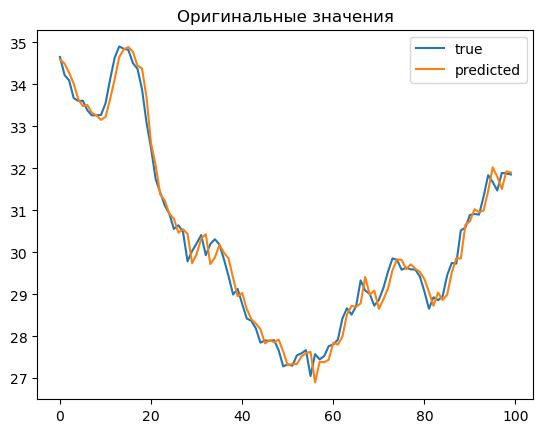

In [250]:
plt.plot(results_training[0][:100, 8], label="true")
plt.plot(results_training[0][:100, Q+8], label="predicted")
plt.legend()
plt.title("Оригинальные значения")
plt.show()

In [251]:
# import csv
# # full_results = np.concatenate((results_training, results_testing), axis=0)
# # full_results = results_training
# full_results = np.concatenate([results_training[:, :2*Q], results_training[:, 4*Q:]], axis=1)
# with open("output_table_03-24.csv", "w") as fout:
#     writer = csv.writer(fout)
#     writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
#     for i in range(full_results.shape[0]):
#         writer.writerow(full_results[i])


In [252]:
# print("weighted mae:", [x[-1] for x in forecasting_training_results])
print(np.mean([x['mae'] for x in metrics_training[2]], axis=1))
print(np.mean([x['mase'] for x in metrics_training[2]], axis=1))
# plt.plot([x['mae'] for x in metrics_training[0]][0])

[0.52246408 0.81142087 0.72919793 0.9459502  0.56943107 0.91231344
 2.05896235]
[4.22260260e+01 5.27200977e+01 4.59942123e+01 2.26277702e+12
 4.33432110e+01 4.78404195e+01 5.62114210e+01]


In [253]:
clusters_sizes = [[np.sum(cur_clusters_labels == i) for i in range(len(np.unique(cur_clusters_labels)))] for cur_clusters_labels in clusters_labels]
N_clusters = len(clusters_sizes)
mae_on_max_cluster = np.array([metrics_training[i][np.argmax(clusters_sizes[i])]['mae'] for i in range(len(forecasting_training_results))])


In [98]:
maes = np.array([[metrics_training[i][c]['mae'] for c in range(N_clusters)] for i in range(len(metrics_training))])
# weighted_mae = np.array([np.average(maes[i, :, :], weights=clusters_sizes[i], axis=0) for i in range(len(forecasting_training_results))])


IndexError: list index out of range

In [254]:
np.mean(mae_on_max_cluster, axis=1)

array([0.60331274, 0.55083819, 0.52246408, 0.60562334, 0.55334059,
       0.53250796, 0.60643055, 0.55870269, 0.52963843, 0.60638499,
       0.56860193, 0.53579372, 0.60497133, 0.57943249, 0.53553123,
       0.58466161, 0.58433438, 0.54069749])

In [ ]:
len(models[1])

In [255]:
results_testing = [Forecasting.predict_through_clusters(dataset_test, clustering_algorithms[i], models[i], W=W) for i in range(len(results_training))]

N_clusters=3
dataset_windows.shape=(13593, 1, 11, 65), labels.shape=(13593,)
IN Clustering.split_to_clusters: mask.sum()=387, 387
IN Clustering.split_to_clusters: mask.sum()=13206, 13206
413/413 [==============================] - 2s 3ms/step
N_clusters=5
dataset_windows.shape=(13593, 1, 11, 65), labels.shape=(13593,)
IN Clustering.split_to_clusters: mask.sum()=12980, 12980
IN Clustering.split_to_clusters: mask.sum()=101, 101
IN Clustering.split_to_clusters: mask.sum()=151, 151
IN Clustering.split_to_clusters: mask.sum()=361, 361
12/12 [==============================] - 0s 3ms/step
N_clusters=7
dataset_windows.shape=(13593, 1, 11, 65), labels.shape=(13593,)
IN Clustering.split_to_clusters: mask.sum()=6373, 6373
IN Clustering.split_to_clusters: mask.sum()=11, 11
IN Clustering.split_to_clusters: mask.sum()=358, 358
IN Clustering.split_to_clusters: mask.sum()=6529, 6529
IN Clustering.split_to_clusters: mask.sum()=207, 207
IN Clustering.split_to_clusters: mask.sum()=115, 115
4/4 [==========

7/7 [==============================] - 0s 3ms/step


In [256]:
len(results_testing)

18

Выбор алгоритма

In [309]:
full_results1 = [np.concatenate((
                    results_training[i],
                    np.concatenate((dataset_test[W:], results_testing[i]), axis=1)
                    ),
                    axis=0
                ) for i in range(len(results_training))]

In [310]:
#tmp
# full_results1 = results_training

In [325]:
global_metrics = [Forecasting.calc_metrics_for_full_results(x) for x in full_results]

In [328]:
# global_metrics
clusters_sizes = [np.array([np.sum(x[:, -2] == i) for i in range(len(np.unique(x[:, -2])))]) for x in full_results]
N_clusters = [len(x) for x in clusters_sizes]
print(N_clusters)
# mae_on_max_cluster = np.array([global_metrics[i][np.argmax(clusters_sizes[i])]['mae'] for i in range(len(full_results))])
# mae_mean = np.array([np.mean(global_metrics[i][np.argmax(clusters_sizes[i])]['mae']) for i in range(full_results)])

[3, 5, 7, 3, 5, 7, 3, 5, 7, 3, 5, 7, 3, 5, 7, 3, 5, 7]


In [329]:
maes = np.array([global_metrics[i]['mae'] for i in range(len(forecasting_training_results))])
mae_on_max_cluster = np.array([
        Forecasting.calc_metrics_for_full_results(
            full_results[i][full_results[i][:, -2] == np.argmax(clusters_sizes[i])]
        )['mae'] 
    for i in range(len(full_results))])

In [330]:
print(np.array(N_clusters).reshape(2, 3, 3))

[[[3 5 7]
  [3 5 7]
  [3 5 7]]

 [[3 5 7]
  [3 5 7]
  [3 5 7]]]


In [315]:
np.around(maes1, decimals=3)

array([[0.02 , 0.033, 0.012, ..., 0.106, 0.632, 0.097],
       [0.021, 0.035, 0.012, ..., 0.108, 0.636, 0.098],
       [0.022, 0.036, 0.012, ..., 0.11 , 0.637, 0.099],
       ...,
       [0.02 , 0.033, 0.012, ..., 0.106, 0.631, 0.097],
       [0.021, 0.034, 0.012, ..., 0.108, 0.634, 0.098],
       [0.021, 0.035, 0.012, ..., 0.11 , 0.638, 0.099]])

In [343]:
print(np.around(np.mean(mae_on_max_cluster, axis=1).reshape(2, 3, 3),decimals=3))

[[[0.712 0.643 0.598]
  [0.72  0.722 0.609]
  [0.721 0.658 0.634]]

 [[0.673 0.673 0.604]
  [0.688 0.687 0.625]
  [0.725 0.689 0.596]]]


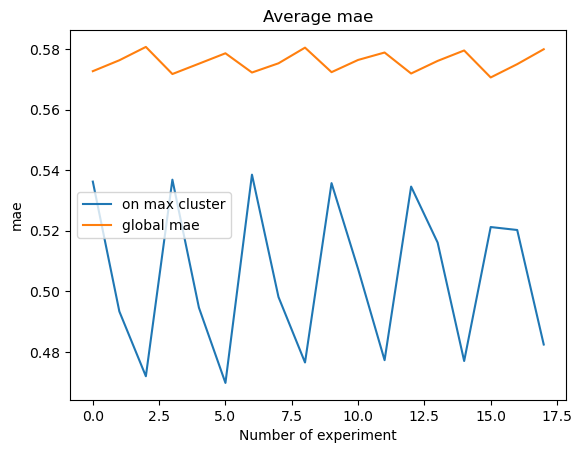

In [332]:
plt.plot(np.mean(mae_on_max_cluster1, axis=1), label="on max cluster")
plt.plot(np.mean(maes1, axis=1), label="global mae")
plt.legend()
plt.title("Average mae")
plt.ylabel("mae")
plt.xlabel("Number of experiment")
plt.show()

In [341]:
ind1 = np.argmin(np.mean(mae_on_max_cluster, axis=1))
ind1

17

Text(0.5, 1.0, 'Размеры кластеров')

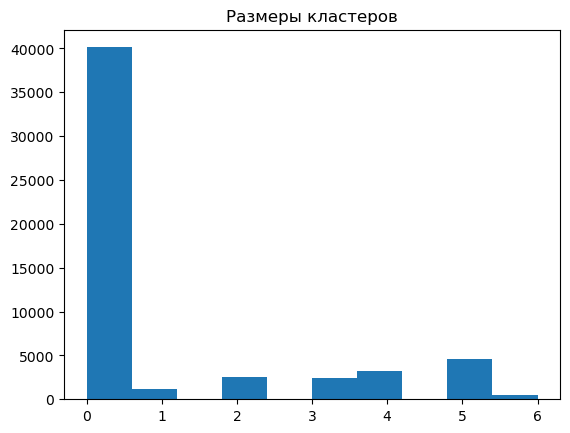

In [334]:
plt.hist(clusters_labels[ind1])
plt.title("Размеры кластеров")

In [336]:
np.mean(global_metrics[ind1]['mase'])

52.64468772985432

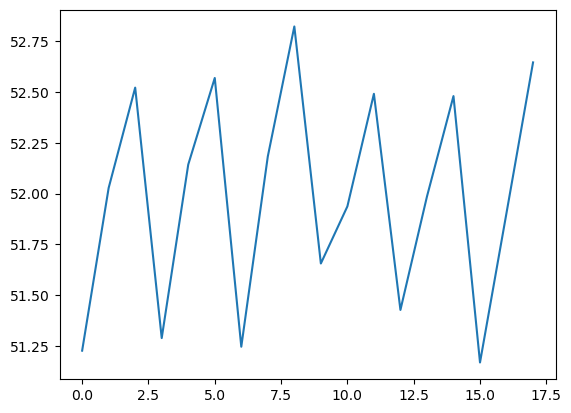

In [337]:
plt.plot([np.mean(x['mase']) for x in global_metrics])

In [338]:
ind2 = np.argmin([np.mean(x['mase']) for x in global_metrics])
ind2, np.mean(global_metrics[ind2]['mase'])

(15, 51.17009220465165)

Тестирование (старое)

In [219]:
#номер сохраняемого эксперимента
IND = 5

In [342]:
import csv
# tmp = np.concatenate((dataset_test[W:], results_testing[0]), axis=1)
# full_results = np.zeros((results_training.shape[0] + results_testing.shape[0], results_training))
# full_results = np.concatenate((results_training[0], tmp), axis=0)
# full_results = results_training
# full_results = np.concatenate([results_training[:, :2*Q], results_training[:, 4*Q:]], axis=1)
with open("output_table_04-06_for60_5.csv", "w") as fout:
    writer = csv.writer(fout)
    writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
    for i in range(full_results1[IND].shape[0]):
        writer.writerow(full_results1[IND][i])


In [ ]:
np.mean(mae_on_max_cluster, axis=1)

In [ ]:
# plt.plot(np.mean([x[-1] for x in forecasting_training_results], axis=1), label="weighted MAE")
# plt.plot(np.mean(mae_on_max_cluster, axis=1), label="MAE on max cluster")
# plt.legend()
# plt.title("MAE on different cluster algorithms")
# plt.show()

In [ ]:
clustering_results1 = [Clustering.apply_clustering(dataset, cur_cluster_alg) for cur_cluster_alg in [Clustering.MeanShift_for_windows(W=W) for W in window_sizes_for_clustering]]


In [ ]:
clusters_labels1 = [x[0] for x in clustering_results1]

clusters_sizes1 = [[np.sum(cur_clusters_labels == i) for i in range(len(np.unique(cur_clusters_labels)))] for cur_clusters_labels in clusters_labels]


In [ ]:
plt.hist(clusters_labels1[-1])
plt.yscale("log")
plt.show()

In [ ]:
np.argmin(np.mean(mae_on_max_cluster, axis=1))

In [ ]:
parameters = {"dif":True, 
              "cluster_algs":clustering_algorithms}
# models, model_mae, results_training = Forecasting.try_parameters(parameters, dataset_train)

In [ ]:
model_mae

In [ ]:
a = np.random.random((5, 4))
sc = Forecasting.MyStandardScaler()
sc.fit(a)
sc.transform(a)
sc.mean, a

Сохранение моделей

In [ ]:
import os
for i, file_name in enumerate(list(os.listdir("scalers"))):
    os.unlink("scalers/"+file_name)
for i in range(len(models['scalers'])):
    with open("scalers/"+str(i)+".pkl", "wb") as f:
        pickle.dump(models['scalers'][i], f)

In [ ]:
os.unlink("clusters_model.pkl")
with open("clusters_model.pkl", "wb") as f:
    pickle.dump(models['clusters_model'], f)


In [ ]:
import os, shutil

for i, file_name in enumerate(list(os.listdir("models"))):
    shutil.rmtree("models/"+file_name)
for i in range(len(models['models'])):
    if not isinstance(models['models'][i], int):
        models['models'][i].save("models/"+str(i))
print(len(models))

Чтение моделей

In [ ]:
import os
N_clusters = len(os.listdir('models'))
assert(len(os.listdir('scalers')) == N_clusters)
models = {'models':[], 'clusters_model':[], 'scalers':[]}

In [ ]:
from tensorflow import keras
for file_name in os.listdir('models'):
    models['models'].append(keras.models.load_model('models/'+file_name))

In [ ]:
for file_name in os.listdir('scalers'):
    with open('scalers/'+file_name, 'rb') as f:
        models['scalers'].append(pickle.load(f))

In [ ]:
with open('clusters_model.pkl', 'rb') as f:
    models['clusters_model'] = pickle.load(f)

Тестирование

In [ ]:
clusters_model = models["clusters_model"]
forecasting_models = models['models']
scalers = models['scalers']
assert(len(forecasting_models) == len(scalers))

In [ ]:
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

In [ ]:
window_sizes_for_clustering

In [ ]:
N_clusters = 7

In [ ]:
# dataset_windows = sliding_window_view(dataset_train, (window_size_clustering, dataset_train.shape[-1])) #(N, 1, W, Q)
# new_shape = dataset_windows.shape
# dataset_windows = dataset_windows.reshape(new_shape[0], new_shape[2] * new_shape[3])
# cluster_nums = clusters_model.labels_
# print(f"{dataset.shape=}, {dataset_windows.shape=}, {cluster_nums.shape=}, {dataset.shape[0] - dataset_windows.shape[0]}")
# cluster_nums = np.pad(cluster_nums, (dataset.shape[0] - dataset_windows.shape[0], 0), mode='constant', constant_values=(cluster_nums[0])) #-1
# print(f"After pad: {dataset.shape=}, {cluster_nums.shape=}")
# # if window_size_clustering > window_size_forecasting:
# #     cluster_num = np.pad(cluster_nums, (0, ), mode='constant', constant_values=(cluster_nums[-1]))
# y_pred = np.zeros((dataset.shape[0] - window_size_forecasting, dataset.shape[-1]))
# #only if dif then +1
# dataset_windows = sliding_window_view(dataset, (window_size_forecasting + 1, dataset.shape[-1]))
# cluster_nums = cluster_nums[window_size_forecasting:] #+1
    
# full_results = np.zeros((cluster_nums.shape[0], 2 * dataset_train.shape[-1] + 2)) # real_Q, Q, cluster_num, mask

# for cluster_num in range(N_clusters):
#     mask = (cluster_nums == cluster_num)
#     if np.sum(mask) == 0:
#         continue

#     cur_windows = dataset_windows[mask, 0, ...] #(M, Wf, Q)
#     scalers[cluster_num].save_first_elements(cur_windows)
#     cur_windows = np.array(scalers[cluster_num].transform(cur_windows))
#     cur_pred = np.array(prediction_models[cluster_num](cur_windows)) #(M, Q)
#     cur_pred = scalers[cluster_num].inverse_transform(cur_pred)
#     cur_pred = scalers[cluster_num].add_first_elements(cur_pred)
#     y_pred[mask] = cur_pred
#     Q = dataset.shape[-1]
#     full_results[mask, Q:2 * Q] = cur_pred
#     full_results[mask, 2 * Q] = cluster_num
#     full_results[mask, 2 * Q + 1] = 3 #global test

In [ ]:
# window_size_for_clustering = clusters_model.cluster_centers_.shape[-1] // dataset_test.shape[-1]
window_size_for_clustering = window_sizes_for_clustering[0]
y_pred, results_testing = Forecasting.predict_through_clusters(dataset_test, clusters_model, forecasting_models, scalers, window_size_clustering=window_size_for_clustering)

In [ ]:
#лучшие параметры
window_size_for_clustering, len(forecasting_models)

In [ ]:
y_pred.shape, dataset.shape[-1]

In [ ]:
print(f"{y_pred.shape=}, {dataset_test.shape=}")
y_true = dataset_test[-y_pred.shape[0]:]
print(y_true.shape, results_testing[:, :dataset_train.shape[-1]].shape)
results_testing[:, :dataset_train.shape[-1]] = y_true
cur_mase = Forecasting.my_mase(y_true, y_pred, multioutput='raw_values')
cur_mae = Forecasting.my_mae(y_true, y_pred, multioutput="raw_values")

In [ ]:
Q = dataset_train.shape[-1]
Q

In [ ]:
import csv
# full_results = np.concatenate((results_training, results_testing), axis=0)
full_results = results_training
with open("output_table_03-23.csv", "w") as fout:
    writer = csv.writer(fout)
    writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
    for i in range(full_results.shape[0]):
        writer.writerow(full_results[i])


In [ ]:
# cur_mase, cur_mae

In [ ]:
# full_results.shape

In [ ]:
mask = cur_mase <= np.percentile(cur_mase, 60)
plt.plot(np.arange(cur_mase.shape[0])[mask], cur_mase[mask])
plt.yscale("log")
plt.xlabel("features")
plt.ylabel("MASE")
plt.title("MASE")
plt.show()

In [ ]:
mask = cur_mae <= np.percentile(cur_mae, 60)
# plt.plot(np.arange(cur_mae.shape[0])[mask], cur_mae[mask])
plt.plot(cur_mae[mask])
plt.xlabel("features")
plt.ylabel("MAE")
plt.title("best MAE")
# plt.show()
plt.savefig("best MAE.png")

In [ ]:
plt.plot(cur_mase[cur_mase <= np.percentile(cur_mase, 100)])
plt.yscale("log")
plt.xlabel("features")
plt.ylabel("MASE")
plt.title("50% best MASE")
plt.show()

In [ ]:
cur_mape = mape(y_true, y_pred)
plt.plot(cur_mape[cur_mape < np.percentile(cur_mape, 50)])
plt.yscale("log")
plt.xlabel("features")
plt.ylabel("MAPE")
plt.title("50% best MAPE")
plt.show()

**Мелкое тестирование**

In [ ]:
N, Q = 1000, 10
# test_array = (np.random.random((N * Q)) + np.sin(np.arange(N * Q) / 100)).reshape(N, Q)
test_array = (np.sin(np.arange(N*Q)/100) * 5).reshape(N, Q)

In [ ]:
test_array

In [ ]:
W = 5
sc = Forecasting.MyStandardScaler()
clusters_X, clusters_labels = Clustering.split_to_clusters(test_array, np.zeros(test_array.shape[0]), W=W + 2)
test_array_windows = clusters_X[0]
X_true, y_true = Forecasting.split_X_y(test_array_windows)
prepared_array = sc.fit_transform(test_array_windows)
prepared_X, prepared_y = Forecasting.split_X_y(prepared_array)
y_changed = sc.inverse_transform(prepared_y)
# array_changed = sc.inverse_transform(prepared_array)

In [ ]:
plt.plot(y_true[:100, 0], label="true")
plt.plot(prepared_y[:100, 0], label="transformed")
plt.legend()
plt.show()

In [ ]:
np.max(np.abs(y_true - y_changed))

In [ ]:
test_labels = np.zeros(N)
# test_labels[test_array[:, 0] <= np.percentile(test_array, 50)] = 1

In [ ]:
test_array.shape

In [ ]:
models, test_results, _ = Forecasting.apply_forecasting_training_simple_version(test_array, test_labels)

In [ ]:
Q = test_array.shape[-1]
plt.plot(test_results[:40, 0], label="true")
plt.plot(test_results[:40, Q], label="predicted")
plt.legend()
plt.show()

In [ ]:
import csv
with open("output_table_03-22.csv", "w") as fout:
    writer = csv.writer(fout)
    writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
    for i in range(test_results.shape[0]):
        writer.writerow(test_results[i])
